In [44]:
from json import loads
from glob import glob
import pandas as pd
import numpy as np
import seaborn as sns

In [45]:
runs = []
for run_output_filepath in glob(
    "./**/test/history/**/*.json", recursive=True
):
    with open(run_output_filepath) as run_output:
        run_json = loads(run_output.read())
        runs.append(run_json)

df = pd.DataFrame(runs)
df = df.rename(columns={
    "lang": "language"
})
df = df.assign(
    payload=lambda df: df["payload"]
    .map(lambda payload: loads(payload.replace('"; "', '", "'))),

    runtime=lambda df: df["runtime"].astype(float),
    roundTripTime=lambda df: df["roundTripTime"].astype(float),
    newcontainer=lambda df: df["newcontainer"].astype(int),

    filter=lambda df: df["payload"].map(lambda payload: payload["filter"]),
    filename=lambda df: df["payload"].map(lambda payload: payload["key"]),
    container_state=lambda df: np.where(
        df["newcontainer"] == 1, "cold", "hot"
    ),
)

In [46]:
grouped_columns = [
    # "cpuType",
    "filename", "filter", "container_state", "language",
]
runtime_results = df.groupby(grouped_columns)["runtime"] \
    .agg(["mean", "std", "count"])
runtime_results = runtime_results.rename(columns={
    "mean": "average runtime (ms)",
    "std": "standard deviation",
    "count": "sample size",
})

runtime_results

average runtime (ms)  \
filename      filter         container_state language                         
deathstar.jpg flipHorizontal cold            java              10468.588235   
                                             node.js            2586.700000   
                             hot             java               2459.238095   
                                             node.js            2225.363636   
              flipVertical   cold            java               9210.833333   
...                                                                     ...   
vietfood.jpg  greyscale      hot             node.js             698.337079   
              soften         cold            java               8103.117647   
                                             node.js            1039.777778   
                             hot             java               1038.378378   
                                             node.js             791.936508   

                                                       standard deviation  \
filename      filter         container_state language                       
deathstar.jpg flipHorizontal cold            java             1078.890058   
                                             node.js           183.128401   
                             hot             java              790.910672   
                                             node.js           210.712610   
              flipVertical   cold            java              844.419345   
...                                                                   ...   
vietfood.jpg  greyscale      hot             node.js           164.187874   
              soften         cold            java              227.900439   
                                             node.js            53.720987   
                             hot             java              541.175488   
                                             node.js           138.017399   

                                                       sample size  
filename      filter         container_state language               
deathstar.jpg flipHorizontal cold            java               17  
                                             node.js            10  
                             hot             java               21  
                                             node.js            66  
              flipVertical   cold            java               18  
...                                                            ...  
vietfood.jpg  greyscale      hot             node.js            89  
              soften         cold            java               17  
                                             node.js             9  
                             hot             java               37  
                                             node.js            63  

[64 rows x 3 columns]

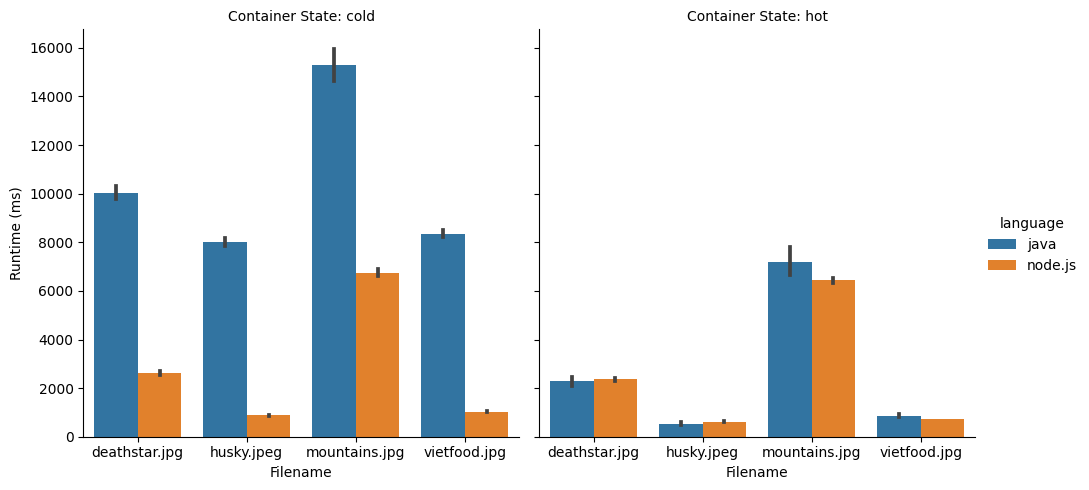

In [47]:
# sns.relplot(df, x="filename", y="runtime", hue="language", col="filter", row="container_state")
results = sns.catplot(
    df, x="filename", y="runtime", hue="language",
    col="container_state",
    kind="bar",
)
results.set_axis_labels("Filename", "Runtime (ms)")
results.set_titles("Container State: {col_name}")

results